In [1]:
import math

import probe_lm
from probe_lm import data_utils, metrics
from probe_lm import plotting_utils

import matplotlib.pyplot as plt
#plt.style.use('dark_background') # for viewing in notebook
plt.style.use('default') # for production of plots for paper/quip

%load_ext autoreload
%autoreload 2

from transformers import GPT2Model, GPT2Config
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel
from tabulate import tabulate

import numpy as np
import pickle

import seaborn as sns
sns.set_theme()

import pandas as pd

from tqdm import tqdm


/opt/conda/envs/renate_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Erasure set experiments

Recall our erasure set definition:
$$S_r = \{ k : \frac{\tilde{p}_k}{p_k}  > r \} $$
One measure of the size of bias is then how large this set is, i.e. for how many countries do we experience erasure.



In [2]:
ground_truth_file_geo= "../data/english-speaking-population-data.txt"
ground_truth_geo = data_utils.read_population_data(ground_truth_file_geo)
ground_truth_geo = probe_lm.normalize_dict(ground_truth_geo)

In [3]:
# read list of basic prompts to extend automatically -- GEOGRAPHY
basic_prompts_geo = data_utils.read_prompts("../data/population-prompts-automatic.txt")
extended_prompts_geo = data_utils.extend_prompt_list(basic_prompts_geo)
# run this twice in order to produce all combinations of pronouns + relations
extended_prompts_geo = data_utils.extend_prompt_list(extended_prompts_geo)

In [4]:
with open('../results_disambiguated/geography_prompt_predictions_open_llama_7b.p', 'rb') as file:
    all_predictions_geo = pickle.load(file) # already normalised
print('The number of predictions is', len(all_predictions_geo)) # same as len(extended_prompts_geo)

The number of predictions is 955


In [5]:
with open('../results_disambiguated/geography_aggregated_predictions_open_llama_7b.p', 'rb') as file:
    aggregated_predictions_geo = pickle.load(file) # already normalised

## Plotting

In [6]:
# r_levels = np.logspace(0, 2, 51)
r_levels = np.linspace(0, 10, 51)

In [7]:
erasure_set_sizes = np.zeros((len(r_levels), len(extended_prompts_geo))) # rows are r levels, columns are repetitions (prompt rephrasings)

for i, r in enumerate(r_levels):
    for j, prompt_prediction in enumerate(all_predictions_geo):
        S = probe_lm.get_erasure_set(prompt_prediction, ground_truth_geo, r)
        erasure_set_sizes[i, j] = len(S)

In [8]:
perc25 = np.percentile(erasure_set_sizes, 25, axis=1, method='hazen')
perc75 = np.percentile(erasure_set_sizes, 75, axis=1)

(0.0, 10.0)

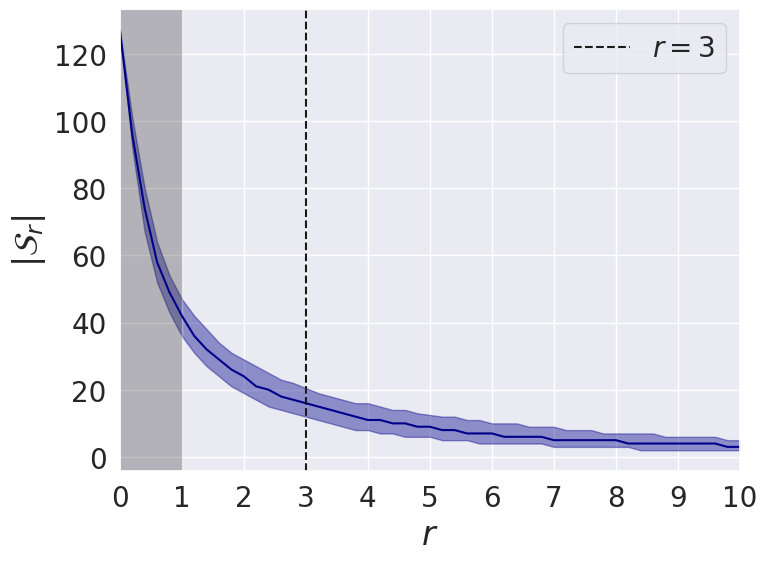

In [9]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 24})
plt.rc('axes', titlesize=24, labelsize=24)
plt.rc('ytick', labelsize=20)
plt.rc('xtick', labelsize=20)

size_medians = np.median(erasure_set_sizes, axis=1)
size_stds = np.std(erasure_set_sizes, axis=1)

fig, ax = plt.subplots(1, figsize=(8, 6))

# from scipy.interpolate import interp1d
# size_means_interpolated = interp1d(r_levels[::4], size_means[::4], kind='linear')

ax.plot(r_levels, size_medians, c='darkblue')
plt.fill_between(r_levels, perc25, perc75,
    alpha=0.4, edgecolor='darkblue', facecolor='darkblue')

#ax.set_xscale('log')
ax.set_xticks(r_levels[::5])

ax.axvline(3, c='k', linestyle='dashed', label='$r=3$')
#labels = [r'$10^0$', '', '', '', '', r'$10^1$', '', '', '', '',  r'$10^2$']
#labels = [r'$10^0$', '', '', '', '', '', '', '', '', '', r'$10^1$', '', '', '', '', '', '', '', '', '', r'$10^2$']
#ax.set_xticklabels(labels)

ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$|\mathcal{S}_r|$')
ax.legend(fontsize=20)
plt.axvspan(-0.2, 1, facecolor='0.2', alpha=0.3) #, zorder=-100)
plt.xlim([0, r_levels[-1]]) 

# plt.savefig('images/method/erasure_set_size.pdf')



### TODO:
- make this plot once for the main text, and then for all models for the appendix 
- make plot pf $E_r$ vs KL divergence

In [10]:
kl, pairwise_off_diags = probe_lm.compute_metrics(all_predictions_geo, ground_truth_geo)  #, use_erasure_set=False, r=10)

In [11]:
median_kl = np.median(kl)
perc25_kl = np.percentile(kl, 25)
perc75_kl = np.percentile(kl, 75)

In [12]:
Er_per_level = []
for r in tqdm(r_levels):
    Er_per_level.append(probe_lm.compute_metrics(all_predictions_geo, ground_truth_geo, use_erasure_set=True, r=r)[0])

100%|██████████| 51/51 [00:03<00:00, 13.29it/s]


In [13]:
median_Er_per_level = np.array([np.median(prompt_kls) for prompt_kls in Er_per_level])
perc25_Er = np.percentile(Er_per_level, 25, axis=1)
perc75_Er = np.percentile(Er_per_level, 75, axis=1)


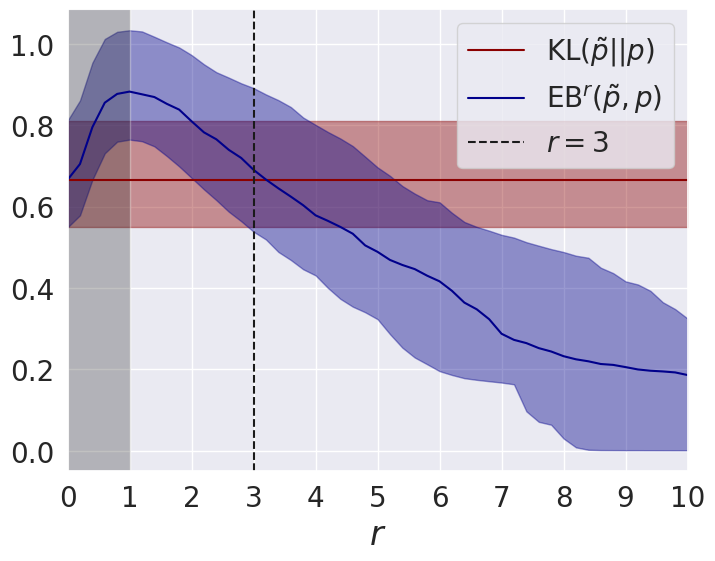

In [14]:
fig, ax = plt.subplots(1, figsize=(8, 6))
#ax.set_xscale('log')

perc25_kl = np.percentile(kl, 25)
perc75_kl = np.percentile(kl, 75)
p1 = ax.plot(r_levels, [median_kl] * len(r_levels) , c='darkred',  label=r'KL$(\tilde{p} || p)$')
ax.fill_between(r_levels, perc25_kl, perc75_kl,
    alpha=0.4, edgecolor='darkred', facecolor='darkred')

perc25_Er = np.percentile(Er_per_level, 25, axis=1)
perc75_Er = np.percentile(Er_per_level, 75, axis=1)
p2 = ax.plot(r_levels,median_Er_per_level , c='darkblue', label=r'EB$^r(\tilde{p},  p)$')
ax.fill_between(r_levels, perc25_Er, perc75_Er,
    alpha=0.4, edgecolor='darkblue', facecolor='darkblue')

ax.set_xticks(r_levels[::5])
# labels = [r'$10^0$', '', '', '', '', r'$10^1$', '', '', '', '',  r'$10^2$']
# ax.set_xticklabels(labels)

p3 = ax.axvline(3, c='k', linestyle='dashed', label='$r=3$')


ax.set_xlabel(r'$r$')
# ax.legend([p1, p2],r'KL$(\tilde{p} || p)$', r'EB$^r(\tilde{p} || p)$', fontsize=20)
ax.legend(fontsize=20)
plt.axvspan(-0.2, 1, facecolor='0.2', alpha=0.3) #, zorder=-100)
plt.xlim([0, r_levels[-1]]) 

plt.savefig('images/method/erasure_set_vs_kl.pdf')

In [15]:
# old plot
# fig, ax = plt.subplots(1, figsize=(8, 6))
# ax.set_xscale('log')

# perc25_kl = np.percentile(kl, 25)
# perc75_kl = np.percentile(kl, 75)
# p1 = ax.plot(r_levels, [median_kl] * len(r_levels) , c='darkred',  label=r'KL$(\tilde{p} || p)$')
# ax.fill_between(r_levels, perc25_kl, perc75_kl,
#     alpha=0.4, edgecolor='darkred', facecolor='darkred')

# perc25_Er = np.percentile(Er_per_level, 25, axis=1)
# perc75_Er = np.percentile(Er_per_level, 75, axis=1)
# p2 = ax.plot(r_levels,median_Er_per_level , c='darkblue', label=r'EB$^r(\tilde{p},  p)$')
# ax.fill_between(r_levels, perc25_Er, perc75_Er,
#     alpha=0.4, edgecolor='darkblue', facecolor='darkblue')

# ax.set_xticks(r_levels[::5])
# labels = [r'$10^0$', '', '', '', '', r'$10^1$', '', '', '', '',  r'$10^2$']
# ax.set_xticklabels(labels)

# p3 = ax.axvline(3, c='k', linestyle='dashed', label='$r=3$')


# ax.set_xlabel(r'$r$')
# # ax.legend([p1, p2],r'KL$(\tilde{p} || p)$', r'EB$^r(\tilde{p} || p)$', fontsize=20)
# ax.legend(fontsize=20, loc=4)

#plt.savefig('images/method/erasure_set_vs_kl.pdf')


## Prediction plots

In [16]:
ground_truth_EBr, erasure_sets_agg =  metrics.compute_metrics([aggregated_predictions_geo], ground_truth_geo, use_erasure_set=True, r=3)

erasure_set_agg = list(erasure_sets_agg[0].keys())

## Combined plots for paper 

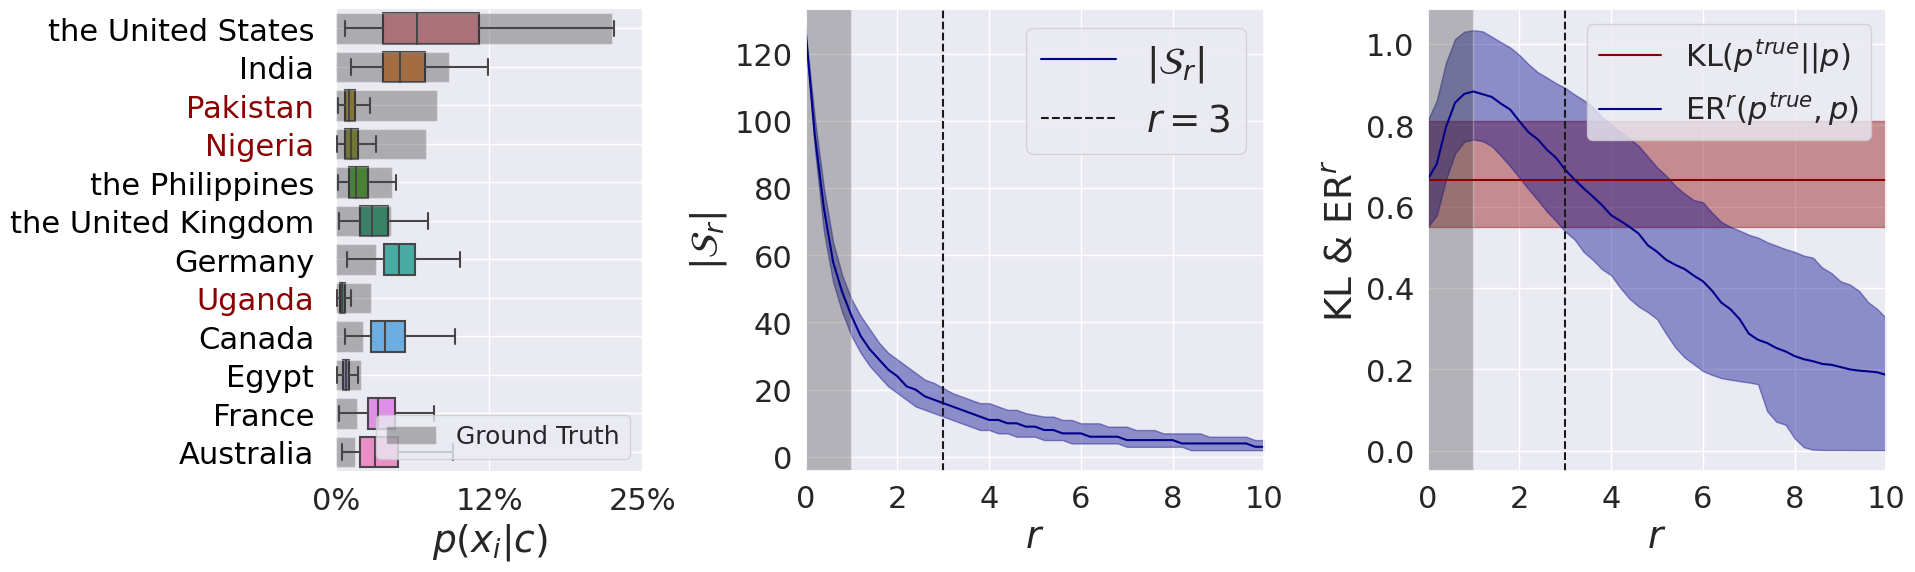

In [18]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 27})
plt.rc('axes', titlesize=27, labelsize=27)
plt.rc('ytick', labelsize=22)
plt.rc('xtick', labelsize=22)

fig, ax = plt.subplots(1, 3, figsize=(20, 6), gridspec_kw={'width_ratios': [2, 3, 3]})
ax = ax.flatten()

################################### PLOT 1

top_k=12
xlim=[0, 25]


# sort the first data dictionary and sort it to get top-k
sorted_list = sorted(ground_truth_geo.items(), key=lambda x: x[1], reverse=True)[
    :top_k
]

x = [i[0] for i in sorted_list]

ground_truth = [ground_truth_geo[key] for key in x]
y = np.empty((len(all_predictions_geo), len(x)))

norm_c = 100.0
for prediction_ix in range(len(all_predictions_geo)):
    y[prediction_ix] = [all_predictions_geo[prediction_ix][key] * norm_c for key in x]
ground_truth = np.array(ground_truth) * norm_c

X_axis = np.arange(len(x))
width = 0.1

# Plot the data in horizontal bar-/boxplot
p1 = ax[0].barh(X_axis, ground_truth, label="Ground Truth", alpha=0.3, color="k")
p2 = sns.boxplot(y, orient='h', showfliers = False, ax=ax[0])


# Remove axes splines
for s in ["top", "bottom", "left", "right"]:
    ax[0].spines[s].set_visible(False)

# Add padding between axes and labels
ax[0].xaxis.set_tick_params(pad=5)
ax[0].yaxis.set_tick_params(pad=10)

ax[0].set_xlim(xlim)

ax[0].set_xlabel(r'$r$')


# set the X axis (e.g., country names)
ax[0].set_yticks(X_axis, x, fontsize=22)

# color country names red if in erasure set
colors = ['darkred' if c in erasure_set_agg else 'black' for c in x ]
for ytick, color in zip(ax[0].get_yticklabels(), colors):
    ytick.set_color(color)

ax[0].set_xlabel(r'$p(x_i|c)$', fontsize=27)

# if xlim is not None:
xvals = np.linspace(0, xlim[-1], 2 + 1)
ax[0].set_xticks(xvals, [f'{int(value)}%' for value in xvals], fontsize=22)

# Add x, y gridlines
ax[0].grid(color="white", linestyle="-", linewidth=1)
# alpha = 0.2)

# add legend
ax[0].legend(fontsize=18) #[p1, p2], ['ground truth', 'predictions'], loc='lower right')

# ################# PLOT 2
size_medians = np.median(erasure_set_sizes, axis=1)
size_stds = np.std(erasure_set_sizes, axis=1)
ax[1].plot(r_levels, size_medians, c='darkblue', label=r'$|\mathcal{S}_r|$')
ax[1].fill_between(r_levels, perc25, perc75,
    alpha=0.4, edgecolor='darkblue', facecolor='darkblue')

# share this axis
ax[1].set_xticks(r_levels[::10])
# ax[1].set_xticklabels(r_levels[::5])


ax[1].axvline(3, c='k', linestyle='dashed', label='$r=3$')
# labels = [r'$10^0$', '', '', '', '', r'$10^1$', '', '', '', '',  r'$10^2$']
# labels = [r'$10^0$', '', '', '', '', '', '', '', '', '', r'$10^1$', '', '', '', '', '', '', '', '', '', r'$10^2$']

# ax[0].set_xlabel(r'$r$')
ax[1].set_ylabel(r'$|\mathcal{S}_r|$')
ax[1].legend(fontsize=27)
ax[1].axvspan(-0.2, 1, facecolor='0.2', alpha=0.3) #, zorder=-100)
ax[1].set_xlim([0, r_levels[-1]]) 
ax[1].set_xlabel(r'$r$')

# ################################### PLOT 3

perc25_kl = np.percentile(kl, 25)
perc75_kl = np.percentile(kl, 75)
p1 = ax[2].plot(r_levels, [median_kl] * len(r_levels) , c='darkred',  label=r'KL$(p^{true} || p)$')
ax[2].fill_between(r_levels, perc25_kl, perc75_kl,
    alpha=0.4, edgecolor='darkred', facecolor='darkred')
perc25_Er = np.percentile(Er_per_level, 25, axis=1)
perc75_Er = np.percentile(Er_per_level, 75, axis=1)
p2 = ax[2].plot(r_levels,median_Er_per_level , c='darkblue', label=r'ER$^r(p^{true},  p)$')
ax[2].fill_between(r_levels, perc25_Er, perc75_Er,
    alpha=0.4, edgecolor='darkblue', facecolor='darkblue')

ax[2].set_xticks(r_levels[::10])
# labels = [r'$10^0$', '', '', '', '', r'$10^1$', '', '', '', '',  r'$10^2$']
# ax.set_xticklabels(labels)

p3 = ax[2].axvline(3, c='k', linestyle='dashed')

ax[2].set_xlabel(r'$r$')
# ax.legend([p1, p2],r'KL$(\tilde{p} || p)$', r'EB$^r(\tilde{p} || p)$', fontsize=20)
ax[2].legend(fontsize=22)
ax[2].axvspan(-0.2, 1, facecolor='0.2', alpha=0.3) #, zorder=-100)
ax[2].set_xlim([0, r_levels[-1]]) 
ax[2].set_ylabel(r'KL & ER$^r$')

plt.subplots_adjust(wspace=0.4)

# lt.tight_layout()
plt.savefig('images/method/preds_erasure_sets_kl_combined.pdf', bbox_inches='tight', pad_inches=0.1)
